In [89]:
from skimage import io, measure
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon

Load RGB image and ground truth labeling for example tile "935655_sw"

In [3]:
rgb = io.imread('sample-data/935655_sw.jpg')
label = io.imread('sample-data/935655_sw.png')

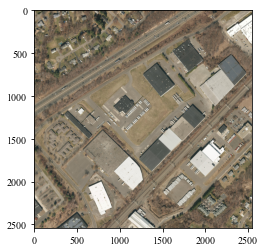

In [94]:
plt.imshow(rgb)

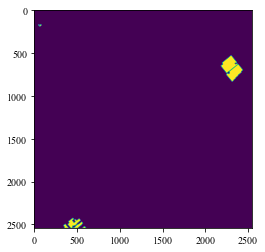

In [95]:
plt.imshow(label)

Load the shapefile which contains corner geospatial coordinates for each tile. This shapefile is not made public but could be requested from the [point of contact in CTECO's website](https://cteco.uconn.edu/metadata/dep/document/ortho_2016_fgdc_plus.htm).

In [5]:
shapefile = gpd.read_file('sample-data/DeliveryGrid2016/DeliveryGrid.shp')

In [10]:
tile_shapefile = shapefile.query('DESCRIPTIO == "935655_sw.tif"')

In [43]:
tile_shapefile.iloc[0]

GM_LAYER                                          Coverage/Quad
GM_TYPE                                           Coverage/Quad
NAME                                              935655_sw.tif
LAYER                                             Coverage/Quad
MAP_NAME                                            shape-1.shp
FILENAME                             S:\0000\TEST\935655_sw.tif
DESCRIPTIO                                        935655_sw.tif
UPPER_LE_X                                            935000.00
UPPER_LE_Y                                            657500.00
LOWER_RI_X                                            937500.00
LOWER_RI_Y                                            655000.00
WEST_LONGI                                   72  59' 11.1520" W
NORTH_LATI                                   41  15' 55.3403" N
EAST_LONGI                                   72  58' 38.3294" W
SOUTH_LATI                                   41  15' 30.5736" N
UL_CORNER_                              

This shapefile contains 2 sets of tile coordinates. We use the ones noted in "UPPER_LE_X", `UPPER_LE_Y`, `LOWER_RI_X`, and `LOWER_RI_Y` as they clearly specified left/right and x/y.

In [55]:
tile_shapefile[["UPPER_LE_X", "UPPER_LE_Y", "LOWER_RI_X", "LOWER_RI_Y"]]

,UPPER_LE_X,UPPER_LE_Y,LOWER_RI_X,LOWER_RI_Y
3052,935000.00,657500.00,937500.00,655000.00


In [52]:
tile_shapefile.EPSG_CODE

3052    EPSG:2234
Name: EPSG_CODE, dtype: object

The CRS used is [EPSG:2234](https://spatialreference.org/ref/epsg/nad83-connecticut-ftus/). (Unit: ftUS).

In [57]:
print(float(tile_shapefile['UPPER_LE_Y']) - float(tile_shapefile['LOWER_RI_Y']))

2500.0


In [58]:
print(float(tile_shapefile['UPPER_LE_X']) - float(tile_shapefile['LOWER_RI_X']))

-2500.0


In [59]:
rgb.shape

(2541, 2541, 3)

As shown above, each side of the tile is 2500 $ft$ long in EPSG:2234 while each side of the RGB image is 2541 pixels long. Therefore, the conversion factor from pixels to ftUS is 2500/2541.

In [67]:
conv_factor = 2500/2541
print(conv_factor)

0.9838646202282566


In [117]:
label_image = measure.label(label)

`measure.label` finds 8 connected group of pixels and assign a distinct integer value (starting from 1) to each group. We take the group whose assigned integer value is 3 as an example.

In [76]:
np.unique(label_image)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

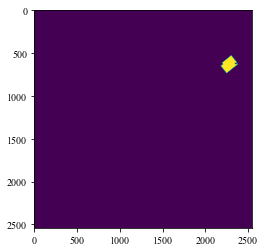

In [83]:
plt.imshow(label_image == 3)

Then we find the bounding box coordinates for the 3rd labeled groups. Format: `(min_row, min_col, max_row, max_col)`.

In [121]:
group_3 = label_image == 3
label_regionprops = measure.regionprops(group_3.astype(np.uint8))

In [123]:
min_row, min_col, max_row, max_col = label_regionprops[0].bbox
print(min_row, min_col, max_row, max_col)

528 2177 736 2377


Note that the origin point of the image in numpy array is at the top left corner but the tile coordinates starts at the bottom left. So the point (`UPPER_LE_X`, `LOWER_RI_Y`) is the corresponding reference point for (`min_row`, `max_col`).

In [112]:
ref_origin_x = float(tile_shapefile['UPPER_LE_X'])
ref_origin_y = float(tile_shapefile['LOWER_RI_Y'])

In [124]:
output_left_x = ref_origin_x + min_col * conv_factor
output_upper_y = ref_origin_y + (2541 - min_row) * conv_factor
output_right_x = ref_origin_x + max_col * conv_factor
output_lower_y = ref_origin_y + (2541 - max_row) * conv_factor

In [125]:
print(output_left_x, output_upper_y, output_right_x, output_lower_y)

937141.873278237 656980.5194805195 937338.6462022825 656775.875639512


Above are the converted coordinates of the bounding box in EPSG:2234. We then make a polygon from these coordinates and convert to EPSG:4326 to get its lat/lon coordinates.

In [126]:
bbox = Polygon(
    [
        (output_left_x, output_lower_y),
        (output_left_x, output_upper_y),
        (output_right_x, output_upper_y),
        (output_right_x, output_lower_y)
    ]
)

bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs='epsg:2234')
bbox_gdf_wgs84 = bbox_gdf.to_crs('epsg:4326')

Output the converted bounding box to GeoJSON format.

In [129]:
bbox_gdf_wgs84['stroke'] = '#FF0000'
bbox_gdf_wgs84.to_json()

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"stroke": "#FF0000"}, "geometry": {"type": "Polygon", "coordinates": [[[-72.97863177478405, 41.2633823303211], [-72.97863374645998, 41.26394397453936], [-72.97791802544394, 41.26394540045209], [-72.97791605993811, 41.263383756219866], [-72.97863177478405, 41.2633823303211]]]}}]}'

In [130]:
converted = io.imread('sample-data/converted.png')

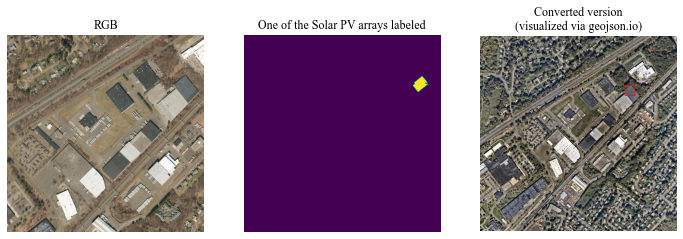

In [132]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(rgb)
ax[1].imshow(group_3)
ax[2].imshow(converted)

for i, name in enumerate(
    [
        'RGB', 
        'One of the Solar PV arrays labeled',
        'Converted version\n(visualized via geojson.io)'
    ]
):
    ax[i].axis('off')
    ax[i].set_title(name)
    
plt.show()